# Coupled Simple Land Simulations

##### Marysa M Laguë
##### 2017.07.05

## Sensitivity Analysis  - total resistance
try to combine the resistance from the bucket and lid, and redo regression analysis on that calculated resistance --- mask out regions where $\beta$ is very small, which makes it hard to calculate the slope (because x values don't change, just look like zeros). 

## Setup 
(This section just has code needed to manipulate the netcdf files, make plots, load data, etc)


In [1]:
# For interactive in-line plots:
#%matplotlib nbagg  

# For inline plots:
%matplotlib inline     

# netcdf/numpy/xarray
import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr
from scipy import interpolate
from numpy import ma
from scipy import stats
import scipy.io as sio
#import cpickle as pickle
import pickle as pickle
from sklearn import linear_model

import time

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import brewer2mpl as cbrew

# OS interaction
import os
import sys

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [2]:
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

### Directories

In [3]:
##### Directory Lists
## Unix
#if 'linux' in sys.platform:
#    dir_pre = '/home/lapok/gdrive/'
## Mac
#elif 'darwin' in sys.platform:
#    dir_pre = '/Users/karllapo/gdrive/'

# My local root directory
dir_root = '/home/disk/eos3/mlague/'

# Where, wrt root, to find the data and save the plots
#dir_data = dir_root + '/cesmruns/SimpleLand/global_pert/'
dir_data = '/home/disk/eos3/mlague/simple_land/output/global_pert/'
dir_fig = dir_root + '/simple_land/scripts/python/analysis/global_pert/figures/sensitivity/'

# Names of the albedo simulations
#sims = ['global_a2_cv2_hc1_rs100',
#       'global_a1_cv2_hc1_rs100','global_a3_cv2_hc1_rs100']
sims = ['global_a2_cv2_hc1_rs100',
       'global_a1_cv2_hc1_rs100','global_a3_cv2_hc1_rs100',
       'global_a2_cv2_hc0.5_rs100','global_a2_cv2_hc2_rs100',
       'global_a2_cv2_hc1_rs30','global_a2_cv2_hc1_rs200']

#load the file paths and # Open the coupled data sets in xarray
cam_files = {}
clm_files = {}
ds_cam = {}
ds_clm = {}

for run in sims:
    #print ( ext_dir + run + '/means/' + run + '.cam.h0.20-50_year_avg.nc' )
    cam_files[run] = dir_data + run + '/means/' + run + '.cam.h0.20-50_year_avg.nc'
    clm_files[run] = dir_data + run + '/means/' + run + '.clm2.h0.20-50_year_avg.nc'
    
    ds_cam[run] = xr.open_dataset(cam_files[run])
    ds_clm[run] = xr.open_dataset(clm_files[run])


# open a cam area file produced in matlab using an EarthEllipsoid from a cam5 f19 lat/lon data set
area_f19_mat = sio.loadmat('/home/disk/eos3/mlague/simple_land/scripts/python/analysis/f19_area.mat')
area_f19 = area_f19_mat['AreaGrid']


#

/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:389: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:408: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


### Functions

##### Plotting

## Maps:

### Pickle a map projection, because it is very slow to make one from scratch

In [4]:
def make_basemap():
    
    dsa = ds_cam['global_a2_cv2_hc1_rs100']
    lat = dsa['lat'].values
    lon = dsa['lon'].values
    dsl = ds_clm['global_a2_cv2_hc1_rs100']
    landmask = dsl['landmask'].values
    
    LN,LT = np.meshgrid(lon,lat)
    
    
    # Make a basic basemap robin projection; this centres the Pacific, which isn't ideal, but 
    # I'll need to roll the data around 180 degrees to make it play nice I think...
    t1 = time.clock()
    
    fig = plt.figure()
    
    mp = Basemap(projection='robin',ellps='WGS84',lon_0=180.,lat_0=0.,resolution='c');
    mp.drawcoastlines()
    #mp.drawcountries()
    mp.drawmapboundary(fill_color='1.')  # make map background white
    parallels = np.arange(-90.,90,20.)
    mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
    meridians = np.arange(0.,360.,20.)
    mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])
    
    #with open(basemap_pkl, 'w') as f:
    #        pickle.dump(mp, f, pickle.HIGHEST_PROTOCOL)
            
    # Pickle the basemap for use later
    #pickle.dump(mp,open(dir_fig + 'map.pickle','wb'),-1)  # pickle it 

    #plt.clf

    print(time.clock()-t1,' secs to create original Basemap instance')
    
    return mp
    # dispose of mp so we don't accidentally use it later. 
    #del mp
    # load the pickle in later:
    # mp = pickle.load( open( dir_fig + 'map.pickle', 'rb' ) )
    
def get_basemap():
    with open(basemap_pkl, 'r') as f:
            return pickle.load(f)
    return mp



In [5]:

def mml_fig(LN,LT,mapdata,ds,myvar,proj=None,title=None,clim=None,colmap=None,units=None):
    #x_data, y_data, x_label, y_label, title=None, xlim=None, ylim=None
    ''' Desctiption of function goes here. Also, single and double quotes are the same...'''

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0, ellps='WGS84',resolution='c') # can't make it start anywhere other than 180???
    mp.drawcoastlines()
    mp.drawmapboundary(fill_color='1.')  # make map background white
    parallels = np.arange(-90.,90,20.)
    mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
    meridians = np.arange(0.,360.,20.)
    mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])
    #(x, y) = m(LONXY, LATXY)
    cs = mp.pcolormesh(LN,LT,mapdata,cmap=plt.cm.inferno,latlon=True)
    
    if cm:
        cs.cmap = colmap
    else:
        cs.cmap = plt.cm.inferno    
    
    cbar = mp.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('units: '+ds[myvar].units)
    
    if title:
        plt.title(title,fontsize=12)
    else:
        plt.title(ds[myvar].long_name,fontsize=12)
    
    if clim:
        cbar.set_clim(clim[0],clim[1])
        cs.set_clim(clim[0],clim[1])
    
    
    
    
    #plt.suptitle('units?')
    #plt.show()
    
    
    #plt.show()
    return fig, mp, ax, cbar, cs

def mml_map(LN,LT,mapdata,ds,myvar,proj,title=None,clim=None,colmap=None,cb_ttl=None):
    # need to have already opened a figure/axis
    #plt.sca(ax)
    
    # There is a way to make a single basemap, save it, and just call that vover and over, ie a blank little map, 
    # that we then build maps on top of (pcolours)
    mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0,resolution='c') # can't make it start anywhere other than 180???
    mp.drawcoastlines()
    mp.drawmapboundary(fill_color='1.')  # make map background white
    parallels = np.arange(-90.,90,20.)
    mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
    meridians = np.arange(0.,360.,20.)
    mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])
    #(x, y) = m(LONXY, LATXY)
    cs = mp.pcolormesh(LN,LT,mapdata,cmap=plt.cm.inferno,latlon=True)
    
    if cm:
        cs.cmap = colmap
    else:
        cs.cmap = plt.cm.inferno    
    
    cbar = mp.colorbar(cs,location='bottom',pad="5%")
    
    cmap.set_bad('white',1.)
    
    if cb_ttl:
        cbar.set_label(cb_ttl,fontsize=12)
    else:
        cbar.set_label('units: '+ds[myvar].units,fontsize=12)
    
    if title:
        plt.title(title,fontsize=12)
    else:
        plt.title(ds[myvar].long_name,fontsize=12)
    
    if clim:
        cbar.set_clim(clim[0],clim[1])
        cs.set_clim(clim[0],clim[1])
    
    
    
    
    #plt.suptitle('units?')
    #plt.show()
    
    
    #plt.show()
    return mp, cbar, cs 



In [6]:
def zonal_fig(data,lat,lev,ds,var,ttl,levels,title=None,clim=None,colmap=None,units=None):
    
    fig = plt.figure(figsize=(6,6))
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    
    mp = plt.contourf(np.sin(lat*np.pi/180),lev,data,levels,cmap=colmap)
    
    mp.set_clim(vmin=clim[0],vmax=clim[1])

    #mp.colorbar()
    #cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
    #cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
    cbar = plt.colorbar(mp)
    #cbar = 
    cbar.set_label(units,fontsize=20)
    #cbar.set_clim(vmin=clim[0],vmax=clim[1])
    #cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
    
    plt.title(ttl)
    plt.ylabel('Pressure [hPa]')
    plt.xlabel('Latitude [degrees N]')

    tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
    tx_name = ['-90','-60','-30','0','30','60','90']
    ax0.set_xticks(tx)
    ax0.set_xticklabels(tx_name)
 
    return mp, cbar

In [7]:
dsa = ds_cam['global_a2_cv2_hc1_rs100']
lat = dsa['lat'].values
lon = dsa['lon'].values
dsl = ds_clm['global_a2_cv2_hc1_rs100']
landmask = dsl['landmask'].values
    
LN,LT = np.meshgrid(lon,lat)
    

# Maps of atmospheric sensitivity of surface perturbation

I'll start with just doing albedo and evaporative resistance, because I need to think a little more about how to deal with the log relationship in roughness. And we probably want to run a hc=2m simulation.



Do the same "regression" to each land point on the earth, calculate the inverse slope (how much of a $\Delta$ surface property is required for a 1 K warming of the 2m air temperature? ... assumes local effect.) 


### Global Response deltas
Calculate the 2m air temperature for each perturbed simulation, in matrix lat x lon form.

### Regression

Now do the regression across the low/med/high perturbations for each of the 3 variables perturbed.
Shape of atm_resp is 3 x 96 x 144
where the size 3 dimension is 1=low 2=med 3=high perturbation. Probably a sleeker dicitonary way to do this, but should make the regression step more straight-forward. I think/hope.

In [8]:

#------------------------------------
# setup some empty dictionaries:
atm_var = {}
prop = {}
units = {}
prop = {}
pert = {}
# annual mean:
atm_resp = {}
# seasonal:
atm_resp_djf = {}
atm_resp_mam = {}
atm_resp_jja = {}
atm_resp_son = {}
# data sets
# atm
ds_low = {}
ds_med = {}
ds_high = {}
# lnd
dsl_low = {}
dsl_med = {}
dsl_high = {}

#------------------------------------
# fill in data sets

# albedo:
ds_low['alb'] = ds_cam['global_a1_cv2_hc1_rs100']
ds_med['alb'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['alb'] = ds_cam['global_a3_cv2_hc1_rs100']

dsl_low['alb'] = ds_clm['global_a1_cv2_hc1_rs100']
dsl_med['alb'] = ds_clm['global_a2_cv2_hc1_rs100']
dsl_high['alb'] = ds_clm['global_a3_cv2_hc1_rs100']

# roughness:
ds_low['hc'] = ds_cam['global_a2_cv2_hc0.5_rs100']
ds_med['hc'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['hc'] = ds_cam['global_a2_cv2_hc2_rs100']

dsl_low['hc'] = ds_clm['global_a2_cv2_hc0.5_rs100']
dsl_med['hc'] = ds_clm['global_a2_cv2_hc1_rs100']
dsl_high['hc'] = ds_clm['global_a2_cv2_hc2_rs100']

# evaporative resistance:
ds_low['rs'] = ds_cam['global_a2_cv2_hc1_rs30']
ds_med['rs'] = ds_cam['global_a2_cv2_hc1_rs100']
ds_high['rs'] = ds_cam['global_a2_cv2_hc1_rs200']

dsl_low['rs'] = ds_clm['global_a2_cv2_hc1_rs30']
dsl_med['rs'] = ds_clm['global_a2_cv2_hc1_rs100']
dsl_high['rs'] = ds_clm['global_a2_cv2_hc1_rs200']


# atmospheric variable to evaluate:
atm_var= 'TREFHT'
ds = ds_low['alb']
units[atm_var] = ds[atm_var].units
   
sfc_props = ['alb','hc','rs']
sfc_prop_ranges = np.array([ [0.1, 0.2, 0.3],
                  [0.5, 1., 2.],
                  [30., 100., 200.]])
print(np.shape(sfc_prop_ranges))

print(sfc_prop_ranges)

i=0

for prop in sfc_props:
    pert[prop] = sfc_prop_ranges[i,:]
    ds1 = ds_low[prop]
    ds2 = ds_med[prop]
    ds3 = ds_high[prop]
    
    # annual mean response
    atm_resp[prop] = [ds1.mean('time')[atm_var].values[:,:],
            ds2.mean('time')[atm_var].values[:,:],
            ds3.mean('time')[atm_var].values[:,:]]
    
    # seasonal responses:
    # (first, make 12 month response, then average over djf, jja, etc)
    #print(np.shape(ds1[atm_var].values))
    resp_mths = np.array([ds1[atm_var].values[:,:,:],
                ds2[atm_var].values[:,:,:],
                ds3[atm_var].values[:,:,:]])
    print(np.shape(resp_mths))
    #print(type(resp_mths))
    #print(resp_mths[:,[11,0,1]])
    atm_resp_djf[prop] = np.mean(resp_mths[:,[11,0,1],:,:],1).squeeze()
    atm_resp_mam[prop] = np.mean(resp_mths[:,[2,3,4],:,:],1).squeeze()
    atm_resp_jja[prop] = np.mean(resp_mths[:,[5,6,7],:,:],1).squeeze()
    atm_resp_son[prop] = np.mean(resp_mths[:,[8,9,10],:,:],1).squeeze()
    print(np.shape(atm_resp_djf[prop]))
    i=i+1

print(np.shape(atm_resp[prop]))
#print(np.shape(atm_resp['alb']))
#print(np.shape(atm_resp['rs']))

# first entry is low perturbation, second is medium, third is high.

(3, 3)
[[  1.00000000e-01   2.00000000e-01   3.00000000e-01]
 [  5.00000000e-01   1.00000000e+00   2.00000000e+00]
 [  3.00000000e+01   1.00000000e+02   2.00000000e+02]]
(3, 12, 96, 144)
(3, 96, 144)
(3, 12, 96, 144)
(3, 96, 144)
(3, 12, 96, 144)
(3, 96, 144)
(3, 96, 144)


In [9]:
# Linear regression

slope = {}
intercept = {}
r_value = {}
p_value = {}
std_err = {}

sensitivity = {}

#linregress doesn't work on arrays

#for prop in sfc_props:
#    
#    slope[prop], intercept[prop], r_value[prop], p_value[prop], std_err[prop] = stats.linregress(pert[prop],atm_resp[prop])
#    
#    
#    
##    print(slope)
#    print(intercept)
##    print(r_value)
#    xs = ax.get_xlim()
#    x = np.linspace(xs[0],xs[1],num=20)
#    y = intercept[prop]+x*slope[prop]
#    lbl = '%.2f' % intercept[prop] + '+ %.2f' % slope[prop] + 'x, r^2 = '+'+ %.4f' % (r_value[prop])**2
##    plin, = plt.plot(x,y,'g-.',linewidth=2.0,label=lbl)
#    
#    # size of surface change required for 1K change in 2m air temperature
#    sensitivity[prop] = slope[prop]**(-1)  
    



In [10]:
# sklearn linear_model , pearson r

# Linear regression

slope = {}
intercept = {}
r_value = {}
p_value = {}
std_err = {}

sensitivity = {}

for prop in sfc_props:
    
    #-----------------------------
    #  Do the regression
    #-----------------------------
    
    # Get the perturbation values, make an np.array (default is list)
    xvals = np.array(pert[prop])
    k = np.size(xvals)
    print(k)
    
    # grab atmospheric response data for current property, make an np.array
    raw_data = np.array(atm_resp[prop])
    # flatten response data into a single long vector (Thanks to Andre for showing me how to do this whole section)
    raw_data_v = raw_data.reshape(k, -1)
    #print(np.shape(raw_data_v))
    #print(np.shape(xvals[:,None]))
    
    
    # create an "empty" model
    model = linear_model.LinearRegression()
    
    # Fit the model to tmp_data
    model.fit(xvals[:, None], raw_data_v)
    
    #  grab the linear fit vector
    slope_vector = model.coef_
    intercept_vector = model.intercept_
    
    # put back into lat/lon (hard coded to be 2.5 degrees right now...)
    slope[prop] = slope_vector.reshape(96,144)
    intercept[prop] = intercept_vector.reshape(96,144)
    
    #-----------------------------
    #   Calculate the r^2 value
    #-----------------------------

    # grab the linear fit using the slope and intercept, so we can calculate the correlation coefficient
    fit_data_v = np.transpose(slope_vector*xvals)
    #print(np.shape(fit_data_v))
    #print(np.shape(raw_data_v))
 
    # Calculate r value
    #r_v, p_v = stats.pearsonr(raw_data_v, fit_data_v)
    %%timeit
    #r_v = np.corrcoef(x=raw_data_v,y=fit_data_v,rowvar=0)
    
    # Going to do this by hand until I figure out how to do it on a matrix...
    #print(np.size(raw_data_v,1))
    x_bar = np.mean(xvals)
    std_x = stats.tstd(xvals)
    #print(x_bar)
    #print(std_x)
    
    #print((np.shape(raw_data_v[1,:])))
    #print(np.shape(raw_data_v))
    #print(np.shape(fit_data_v))
    r_v = np.zeros(np.shape(raw_data_v[0,:]))
    p_v = np.zeros(np.shape(raw_data_v[0,:]))
    #print(np.shape(r_v))
    
    for j in range(np.size(raw_data_v,1)):
       
        # compare to using the pearson-r function:
        r, p = stats.pearsonr(raw_data_v[:,j],fit_data_v[:,j])
        r_v[j] = r
        p_v[j] = p

  
    #print(np.shape(r_v.reshape(96,144)))
    
    r_value[prop] = r_v.reshape(96,144)
    p_value[prop] = p_v.reshape(96,144)



3
3
3


()


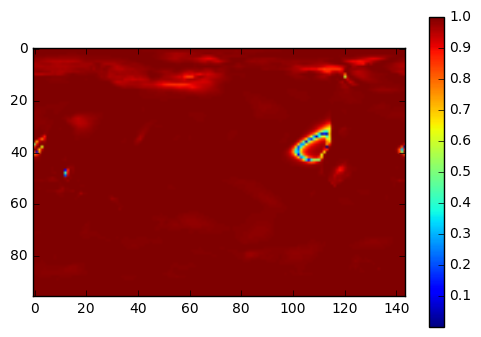

In [11]:
plt.imshow(r_value['alb'])
print(np.shape(r_value))
plt.colorbar()

In [12]:

#cmap =  plt.cm.viridis
#cmap.set_bad('white',1.)

#plt.imshow(np.array(slope['alb']))
#plt.colorbar()

Well that was rather too hard... but now I should have the slope and the r value on a map (CHECK IF THEY'RE RIGHT AGAINS POINT PLOTS), for each simulation. 

# Plot maps of sensitivity
(and r^2)

I'll plot 1 x 3 maps, setup in as the following:

  inverse slope  |   slope   | r^2
  
Where:
- inverse slope is the magnitude of land change required to drive a 1K change in atm temperature
- slope is the (calculated above) slope of the delta atm / delta land, ie per 1 increment change in land property, how much change in 2m air temperature do you get?
- r^2 is the square of the r value calculated above.


In [13]:
ds = ds_clm['global_a2_cv2_hc1_rs100']
lat = ds['lat'].values
lon = ds['lon'].values
landmask = ds['landmask'].values
landmask_nan = np.where(landmask==1,landmask,np.nan)
ocnmask_nan = landmask_nan.copy
ocnmask_nan = np.where(landmask==1,np.nan,1)

LN,LT = np.meshgrid(lon,lat)

# Get a glacier mask, too!
temp = np.mean(ds.mean('time')['MML_cv'].values[:],0)
print(np.shape(temp))
#plt.imshow(temp)
#plt.colorbar()
temp2 = temp.copy()
is_glc = np.where(temp2>1950000,np.nan,1)*landmask_nan
no_glc = np.where(temp2>1950000,1,np.nan)


ocn_glc_mask = ocnmask_nan.copy()
ocn_glc_mask = np.where(np.isnan(is_glc)==False,1,ocn_glc_mask)

bareground_mask = ocn_glc_mask.copy()
bareground_mask = np.where(np.isnan(ocn_glc_mask),1,np.nan)

#plt.imshow(bareground_mask)
#plt.colorbar()


(96, 144)


In [14]:

cmap =  plt.cm.viridis
cmap.set_bad([.3, .3, .3],alpha=1.)
cmap.set_bad('m',alpha=1.)

#plt.imshow(np.array(slope['alb'])*landmask_nan)
#plt.colorbar()

In [15]:
cmap =  plt.cm.viridis
cmap.set_bad([.3, .3, .3],alpha=1.)
cmap.set_bad('m',alpha=1.)

#plt.imshow(np.array(slope['alb'])*ocnmask_nan)
#plt.colorbar()

In [16]:
#print(landmask_nan)

# To-do:
- recalculate albedo regression using *effective* surface albedo change (calculate sfc albedo - see how much the sensitivity differes (should only matter at high latitudes) )
- calculate the TOTAL resistance, which is the combination of the bucket resistance and surface resistance; recalculate sensitivity, now using *total* resistance as the variable (might be a tad harder, as the x-axis is not not uniform across gridcells, so just might have to modify some code). 
- make a map of where surface resistance vs bucket resistance dominates signal -- Note: this ought to be sensitive to the magnitudes of bucket I chose (200 vs 5 mm) . 
- also do sensitivity just using bucket resistance portion... (ie beta). 

## Effective Resistance ("lid" resistance + "bucket" resistance)

First, calculate *beta*, the multiplier on resistance which is due to bucket "fullness":
$$ \beta = \min{[\frac{w}{0.75  BC},1]}$$
where $w$ is the total amount of water currently in the bucket (in kg/m$^2$), and $BC$ is the bucket capacity (in kg/m$^2$). 

The total conductivity of the bucket-lid system is equal to $\frac{\beta}{res}$, where $res$ is the evaporative resistance, which is a function of the prescribed lid evaporative resistance $r_s$ and the aerodynamic resistnace for heat $r_{ah} = \frac{\theta_{ref} - T_{srf}}{u^*T^*}$ (calculated using Monin-Obukhov theory, which also requires information about the surface roughness $h_c$): 

$$ res = r_s + r_{ah} $$

The total latent heat flux (water evaporated) is calculated as 

$$ LH = \rho_{air} \lambda ( q_{srf} - q_{ref}) \frac{\beta}{res} $$

where $q$ is the specific humidity [kg/kg], and $\lambda$ is the latent heat of vaporation (or sublimation, if below freezing). There are some modifications to this equation to ensure more water isn't evaporated than is available. 

# * I really ought to move all of this into a separte script. This one is getting long, and I'm overwriting things I might want to be keeping!!!*

In [17]:
beta = {}
w = {}
BC = {}
runoff = {}

# might as well calculate it for all the runs - may give something interesting... 
for prop in sfc_props:
    ds1 = dsl_low[prop]
    ds2 = dsl_med[prop]
    ds3 = dsl_high[prop]
    
    # bad coding, ought to loop over this...
    w['low'] = ds1['MML_water'].values[:]
    BC['low'] = ds1['MML_bucket_cap'].values[:]
    runoff['low'] = ds1['MML_runoff'].values[:]
    
    w['med'] = ds2['MML_water'].values[:]
    BC['med'] = ds2['MML_bucket_cap'].values[:]
    runoff['med'] = ds2['MML_runoff'].values[:]
    
    w['high'] = ds3['MML_water'].values[:]
    BC['high'] = ds3['MML_bucket_cap'].values[:]
    runoff['high'] = ds3['MML_runoff'].values[:]
    
    


Specifically focus on evaporative resistance perturbed simulations for the moment:
## $r_s$ only for now

In [18]:
beta = {} # soil beta factor, between 0 (dry) and 1 (wet)
res={}    # lid resistance, combination of prescribed evap_rs and MO resistance for heat
cond = {} # total conductivity [m/s] = beta/res
LH_ptl = {}  # potential lhflx if beta = 1
LH_real = {} # actual lhflx with beta calculated   ... difference LH_ptl - LH_real = LH suppression due to dry bucket, should scale with beta

# have to identify when beta dominates vs when res dominates... if beta is small, but res is very large, res might be more important. 
# compare 1/beta to res? the larger value is the one that is dominant. 

w = {}
BC = {}
runoff = {}
beta_mask = {}   # mask where beta is less than some threshold given by beta_min

beta_min = 0.3

prop = 'rs'

ds_list = {}

ds1 = dsl_low[prop]
ds2 = dsl_med[prop]
ds3 = dsl_high[prop]

ds_list['low'] = dsl
ds_list['med'] = ds2
ds_list['high'] = ds3
    
# bad coding, ought to loop over this...
mag_perts = ['low','med','high']

for mag in mag_perts:
    ds = ds_list[mag]
    w[mag] = ds['MML_water'].values[:]
    BC[mag] = ds['MML_bucket_cap'].values[:]
    runoff[mag] = ds['MML_runoff'].values[:]
    
    beta[mag] = np.minimum(w[mag]/(0.75*BC[mag]),1.0)
    res[mag] = ds['MML_evap_rs'].values[:]  +  ds['MML_rah'].values[:] 
    cond[mag] = beta[mag]/res[mag]
    
    # beta mask: where beta is < beta_min, set to nan
    beta_m_temp = np.ones(np.shape(beta[mag]));
    beta_mask[mag] = np.where(beta[mag]>beta_min,1,np.nan)


# compare 1/beta to res in magnitude; the one that is larger I THINK is the one that is dominant at that location.
# BUT the units wouldn't be the same... would the magnitude really tell me much? Well, lets plot it and see what it looks like...




In [19]:
np.shape(beta[mag])
aa=np.ones(np.shape(beta[mag]))*np.nan;
print(np.shape(aa))

(12, 96, 144)


Make a new "atmospheric sensitivity" field, where the places with beta_mask = nan are masked out. Also calculate an "effective resistance" which is equal to the total (beta + lid) resistance, again with the beta_masked regions masked out.



In [20]:
atm_sens_effective = {}
sfc_res_effective = {}

prop = 'rs'

del(ds_list)

ds_list = {}

ds1 = ds_low[prop]
ds2 = ds_med[prop]
ds3 = ds_high[prop]

ds_list['low'] = ds1
ds_list['med'] = ds2
ds_list['high'] = ds3

    
# bad coding, ought to loop over this...
mag_perts = ['low','med','high']

# Still looking at 2m air T
atm_var= 'TREFHT'


In [21]:
for mag in mag_perts:
    del(ds)
    ds = ds_list[mag]
    mask = np.copy(beta_mask[mag])
#    print(np.shape(mask))
#    print(np.shape(res[mag]))
    sfc_res_effective[mag] = np.mean(res[mag]*mask,0)
#    print(np.shape(sfc_res_effective[mag]))
    
    atm_sens_effective[mag] = np.mean(ds[atm_var].values*mask,0)
#    print(np.shape(atm_sens_effective[mag]))
    

Put the *masked* atmospheric response and surface resistance forcing into vectors to run through the linear fit model.

In [22]:
atm_resp_masked = [atm_sens_effective['low'], atm_sens_effective['med'], atm_sens_effective['high']]
#print(np.shape(atm_sens_effective['low']))
#print(np.shape(atm_resp_masked))
sfc_restot_masked = [sfc_res_effective['low'], sfc_res_effective['med'], sfc_res_effective['high']]

Now do the model linear fit:

In [47]:
# sklearn linear_model , pearson r

# Linear regression

slope = np.zeros(np.shape(sfc_res_effective['low']))
intercept = np.zeros(np.shape(sfc_res_effective['low']))
r_value = np.zeros(np.shape(sfc_res_effective['low']))
p_value = np.zeros(np.shape(sfc_res_effective['low']))
std_err = np.zeros(np.shape(sfc_res_effective['low']))

sensitivity = {}

# Having trouble getting it to use the non-static x values (they vary spatially), so I'm going to
# (gasp!) loop (shudder) over all the land points (sigh)... it'll be slow, but it should work.

# In this case, don't use the masked version of stuff, as I can use the loop to identify an appropriate masking value.

%timeit range(100)
# loop over latitudes:
for lt in range(np.size(lat))  :
    # loop over longitudes:
    for ln in range(np.size(lon)) :
        # Goal: do the regression at each point, and store in a matrix.
        
        # First, create an empty matrix for the local point's slope, r value, p value, error, intercept
        
        
        # Create a vector of the "x values" given by the total resistance (does it matter if they're not monotonic? hope not.)
        # sfc_res_effective[mag] is size 96 x 144
        xvals = [np.mean(res['low']*mask,0)[lt,ln], \
                 np.mean(res['med']*mask,0)[lt,ln], \
                 np.mean(res['high']*mask,0)[lt,ln]]
        
        xvals = [np.mean(res['low'],0)[lt,ln], \
                 np.mean(res['med'],0)[lt,ln], \
                 np.mean(res['high'],0)[lt,ln]]
        #print(np.shape(xvals))
        
        # Create a vector of the "y values" given by the atmospheric state
        yvals = np.squeeze(np.array(atm_resp[prop])[:,lt,ln])
        
        #print(np.shape(yvals))
        
        
        # do a quick and dirty slope approximation. I'm not sure what the threshold to crash the linear_fit model is...
        slope[lt,ln], intercept[lt,ln], r_value[lt,ln], p_value[lt,ln], std_err[lt,ln] = \
            stats.linregress(xvals,yvals)

        # see if that matches where beta is small. It ought to.
        
print('done looping over lat/lon')       
        
   

The slowest run took 4.42 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 317 ns per loop
done looping over lat/lon


inverse slope

In [48]:
sensitivity = slope**(-1)

In [49]:
print(np.shape(sensitivity))

(96, 144)


# Sensitivity plots!

### Land masked

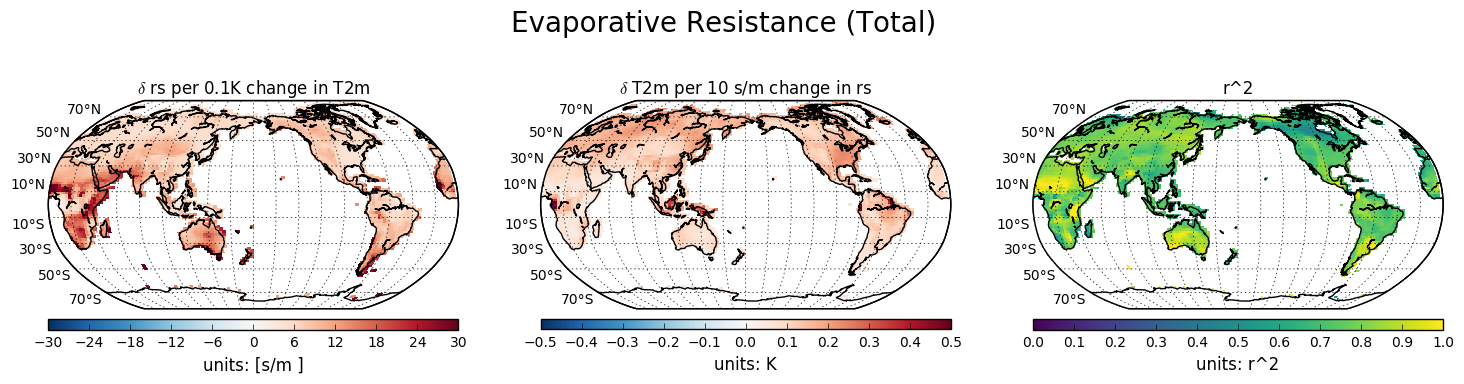

In [53]:
prop = 'rs'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']

mapdata_slope = slope
mapdata_inv = slope**(-1.)
mapdata_r2 = r_value**2.


ttl_main = 'Evaporative Resistance (Total)'
filename = 'sens_slopes_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = '$\delta$ '+prop+' per 0.1K change in T2m'
units = '[s/m ]'
clim_diff = [-30.,30.]
mapdata = mapdata_inv*bareground_mask*0.1
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = '$\delta$ T2m per 10 s/m change in '+prop
units = 'K'
clim_diff = [-0.5,0.5]
clim_abs = clim_diff
mapdata = mapdata_slope*bareground_mask*10
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'r^2'
units = 'r^2'
clim_abs = [0,1]
mapdata = mapdata_r2*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


In [27]:
# run loop over regular lid resistance and plot magnitudes of that (plot that is right above this) for just lid

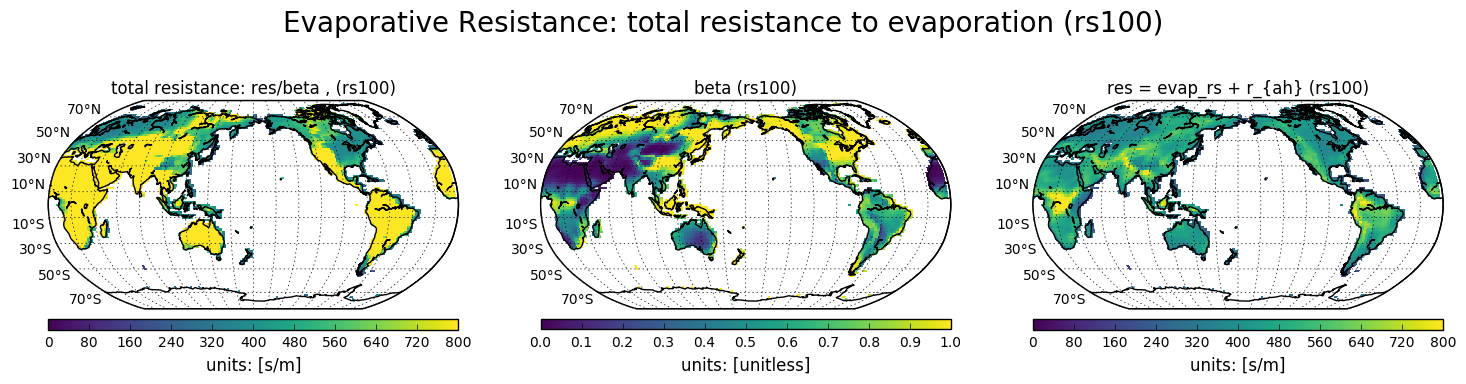

In [28]:
prop = 'rs'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']



ttl_main = 'Evaporative Resistance: total resistance to evaporation (rs100)'
filename = 'total_resistance_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'total resistance: res/beta , (rs100)'
units = '[s/m]'
clim_diff = [-200.,200.]
clim_abs = [0.,800.]
mapdata = np.mean((res['med']/beta['med'] ),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'beta (rs100)'
units = '[unitless]'
clim_diff = [-.2,.2]
clim_abs = [0,1]
mapdata = np.mean((beta['med'] ),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'res = evap_rs + r_{ah} (rs100)'
units = '[s/m]'
clim_abs = [0.,800.]
clim_diff = [-200,200]
mapdata = np.mean((res['med']),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


Now make a two colour plot showing where beta is > or < than 0.5; I'll call places with beta < 0.5 bucket dominated, and places with beta > 0.5 surface dominated. This isn't really fair though... a high beta just means the bucket won't impact the calculation as much... but if res is still weak, then the bucket might actually be the *more* imporant one. Not sure how to quanitfy this. 

Changed my mind. Instead, make a plot of total resistance res/beta - "prescribed" resistance res
ie
$$\frac{res}{\beta} - res = res \big( \frac{1}{\beta} -  1\big) = \frac{res - res*\beta }{\beta} = res\frac{1-\beta}{\beta} $$

...
that should tell me... how much of the total resistance, in [s/m], is attributable to the division by $\beta$. Comparing that to the regular $res$ might be interesting.

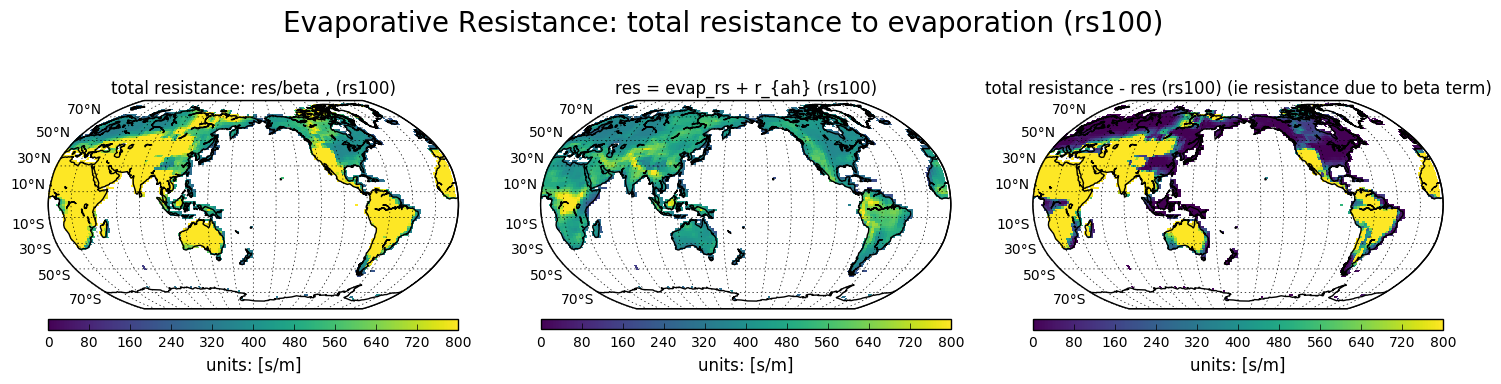

In [29]:
prop = 'rs'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']



ttl_main = 'Evaporative Resistance: total resistance to evaporation (rs100)'
filename = 'total_resistance_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'total resistance: res/beta , (rs100)'
units = '[s/m]'
clim_diff = [-200.,200.]
clim_abs = [0.,800.]
mapdata = np.mean((res['med']/beta['med'] ),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'res = evap_rs + r_{ah} (rs100)'
units = '[s/m]'
clim_abs = [0.,800.]
clim_diff = [-200,200]
mapdata = np.mean((res['med']),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'total resistance - res (rs100) (ie resistance due to beta term)'
units = '[s/m]'
clim_abs = [0.,800.]
clim_diff = [-200,200]
mapdata = (np.mean((res['med']/beta['med'] ),0).squeeze() - np.mean((res['med']),0).squeeze())*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


right hand plot looks to match where beta is low, which would be consistent with the beta factor being important there. Question is, is it literally the same plot just with funny / flipped units, in which case I'm making this overly complicated...

In [30]:
print(np.nanmax(np.mean((res['med']/beta['med'] ),0).squeeze()))
print(np.nanmax(np.mean((res['med']),0).squeeze()))
print(np.nanmin(np.mean((beta['med'] ),0).squeeze()))
print(1./np.nanmin(np.mean((beta['med'] ),0).squeeze()))
print(1./np.nanmin(np.mean((beta['med'] ),0).squeeze())*np.nanmax(np.mean((res['med']),0).squeeze()))

241961.487767
997.398874919
0.00572697777715
174.612166995
174157.978908


Are interested in how this value changes with our experiments - 

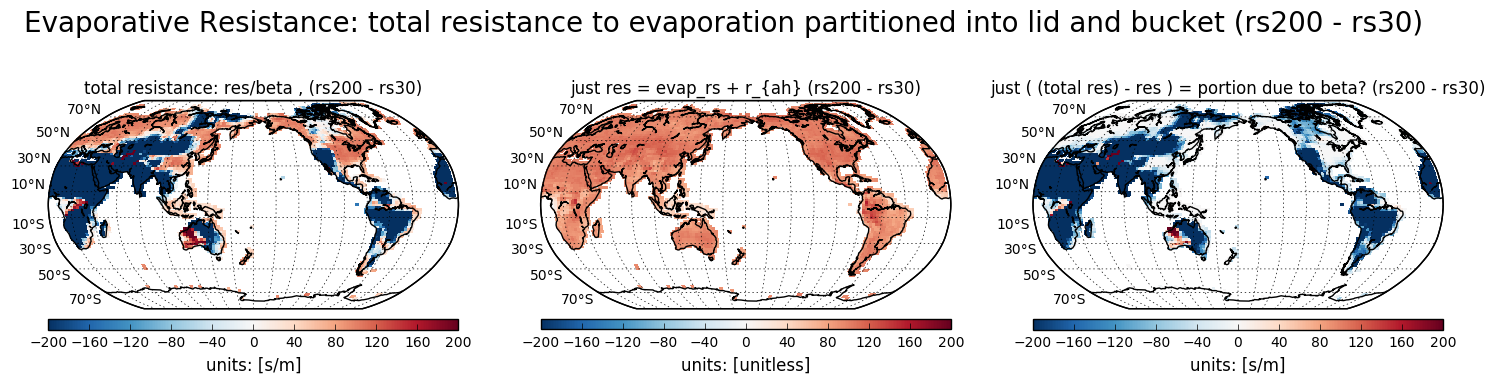

In [31]:
prop = 'rs'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']



ttl_main = 'Evaporative Resistance: total resistance to evaporation partitioned into lid and bucket (rs200 - rs30)'
filename = 'delta_total_resistance_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'total resistance: res/beta , (rs200 - rs30)'
units = '[s/m]'
clim_diff = [-200,200]
clm_abs = [0,2]
mapdata = np.mean((res['high']/beta['high'] - res['low']/beta['low']),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'just res = evap_rs + r_{ah} (rs200 - rs30)'
units = '[unitless]'
clim_diff = [-200,200]
clim_abs = [0,1]
mapdata = np.mean((res['high'] - res['low']),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'just ( (total res) - res ) = portion due to beta? (rs200 - rs30)'
units = '[s/m]'
clim_abs = [0.5,1]
clim_diff = [-200,200]
mapdata = np.mean((res['high']*(1/beta['high']-1) - res['low']*(1/beta['low']-1)),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


The fact that there is a small amount of texture in the center panel above, even though rs was globally fixed and hc between the two runs was identical, must be due to changes in the atmosphereic state feeding back on the obukhov length and thus impacting rah, the roughness length for heat. 

Its really washing out the maps with 1/beta terms, because it can lead to very large values when beta is near-zero (ie empty bucket). So, is the bucket really empty in those places? Lets plot some bucket variables:

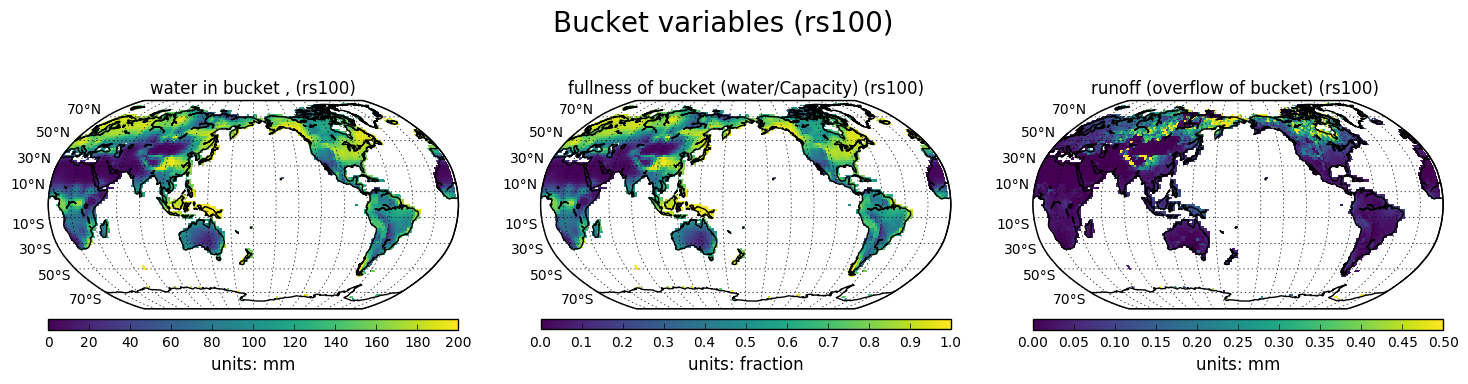

In [32]:
prop = 'rs'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']



ttl_main = 'Bucket variables (rs100)'
filename = 'total_resistance_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'water in bucket , (rs100)'
units = 'mm'
clim_diff = [-200.,200.]
clim_abs = [0.,200.]
mapdata = np.mean((w['med'] ),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'fullness of bucket (water/Capacity) (rs100)'
units = 'fraction'
clim_abs = [0.,1.]
clim_diff = [-200,200]
mapdata = np.mean((w['med']/BC['med']),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'runoff (overflow of bucket) (rs100) '
units = 'mm'
clim_abs = [0.,0.5]
clim_diff = [-200,200]
mapdata = (np.mean((runoff['med'] ),0).squeeze() )*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


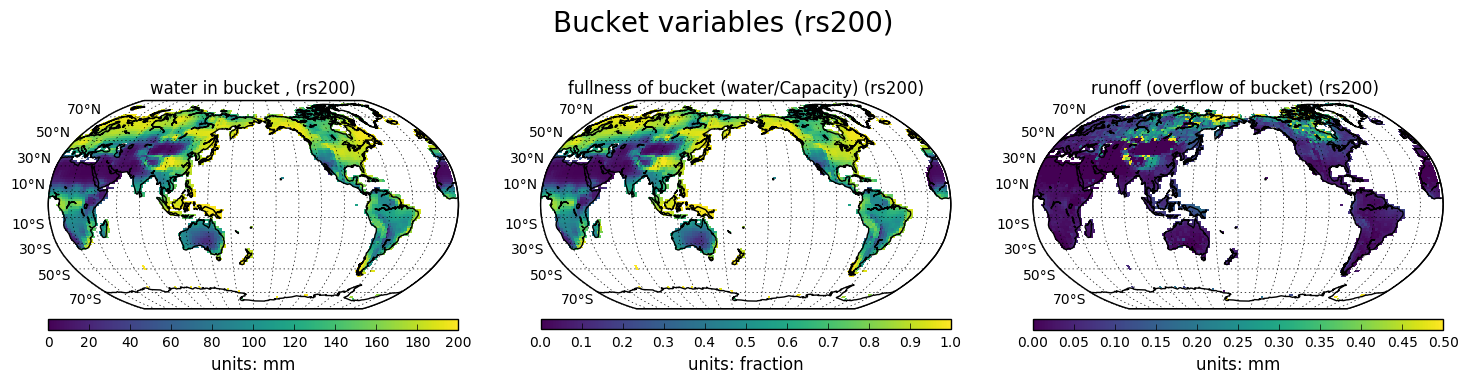

In [33]:
prop = 'rs'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']



ttl_main = 'Bucket variables (rs200)'
filename = 'total_resistance_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0)
ttl = 'water in bucket , (rs200)'
units = 'mm'
clim_diff = [-200.,200.]
clim_abs = [0.,200.]
mapdata = np.mean((w['high'] ),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'fullness of bucket (water/Capacity) (rs200)'
units = 'fraction'
clim_abs = [0.,1.]
clim_diff = [-200,200]
mapdata = np.mean((w['high']/BC['high']),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'runoff (overflow of bucket) (rs200) '
units = 'mm'
clim_abs = [0.,0.5]
clim_diff = [-200,200]
mapdata = (np.mean((runoff['high'] ),0).squeeze() )*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_abs,colmap=cmap_abs, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


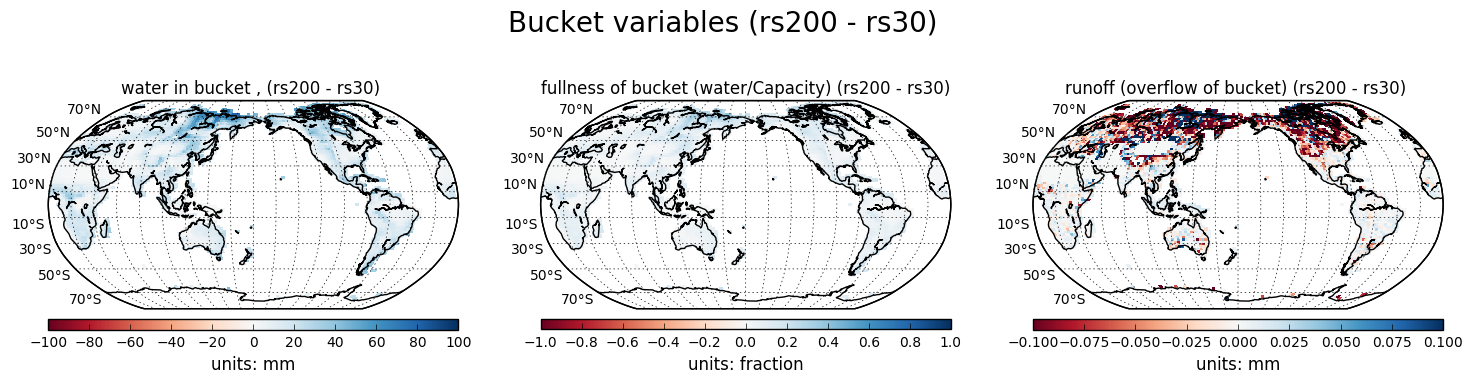

In [34]:
prop = 'rs'
myvar = 'TREFHT'
ds0 = ds_cam['global_a2_cv2_hc1_rs100']



ttl_main = 'Bucket variables (rs200 - rs30)'
filename = 'total_resistance_'+prop


cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

fig, axes = plt.subplots(1, 3, figsize=(18,6))

ax0 = axes.flatten()[0]
plt.sca(ax0) 
ttl = 'water in bucket , (rs200 - rs30) '
units = 'mm'
clim_diff = [-100.,100.]
clim_abs = [0.,200.]
mapdata = np.mean((w['high'] ) - (w['low'] ),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax0
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax1 = axes.flatten()[1]
plt.sca(ax1)
ttl = 'fullness of bucket (water/Capacity) (rs200 - rs30)'
units = 'fraction'
clim_abs = [0,1.]
clim_diff = [-1.,1.]
mapdata = np.mean((w['high']/BC['high']) - (w['low']/BC['low']),0).squeeze()*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax1
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax2 = axes.flatten()[2]
plt.sca(ax2)
ttl = 'runoff (overflow of bucket) (rs200 - rs30) '
units = 'mm'
clim_abs = [0.,0.5]
clim_diff = [-0.1,0.1]
mapdata = (np.mean((runoff['high'] - runoff['low']),0).squeeze() )*bareground_mask
mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
mml_map(LN,LT,mapdata,ds0,myvar,'moll',title=ttl,clim=clim_diff,colmap=cmap_diff, cb_ttl='units: '+units )   #plt.cm.BuPu_r
ax=ax2
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

fig.subplots_adjust(top=1.15)
fig.suptitle(ttl_main, fontsize=20)    
    
#plt.savefig(figpath+'/roughness/'+filename+'.eps', bbox_inches='tight')
#fig_name = figpath+'/sensitivity/'+filename+'.eps'
#fig.savefig(fig_name,dpi=1200,transparent=True,facecolor='w',
#            edgecolor='w',orientation='portrait',bbox_inches='tight', 
#            pad_inches=0.1,frameon=None)


There is LESS overflow when resistance is high? Isn't that counter-intuitive? Though magnitudes of runoff are pretty piddly... see how this compares in the bc5 vs bc200 experiments.

## Atmospheric Sensitivity to TOTAL resistance $r = \frac{res}{\beta}$
(where $res = r_{ah} + r_s$, for $r_s$ the prescribed "bulk" lid resistance, and $r_{ah}$ the aerodynamic resistance due to heat). 

1 - Calculate the total resistance $r$ for each grid point during each experiment (won't get a big $\delta r$ in regions that are bucket dominated, and thus have $r$ domainated by $\beta$ with little effect of varying $r_s$). 

In [35]:
beta = {} # soil beta factor, between 0 (dry) and 1 (wet)
res_lid={}    # lid resistance, combination of prescribed evap_rs and MO resistance for heat
res_tot = {}    # total resistance = res/beta
res_beta = {} # bucket resistance, b_res = res/beta - res
cond = {} # total conductivity [m/s] = beta/res
LH_ptl = {}  # potential lhflx if beta = 1
LH_real = {} # actual lhflx with beta calculated   ... difference LH_ptl - LH_real = LH suppression due to dry bucket, should scale with beta

# have to identify when beta dominates vs when res dominates... if beta is small, but res is very large, res might be more important. 
# compare 1/beta to res? the larger value is the one that is dominant. 

w = {}
BC = {}
runoff = {}

prop = 'rs'

ds_list = {}

ds1 = dsl_low[prop]
ds2 = dsl_med[prop]
ds3 = dsl_high[prop]

ds_list['low'] = dsl
ds_list['med'] = ds2
ds_list['high'] = ds3
    
# bad coding, ought to loop over this...
mag_perts = ['low','med','high']

for mag in mag_perts:
    ds = ds_list[mag]
    w[mag] = ds['MML_water'].values[:]
    BC[mag] = ds['MML_bucket_cap'].values[:]
    runoff[mag] = ds['MML_runoff'].values[:]
    
    beta[mag] = np.minimum(w[mag]/(0.75*BC[mag]),1.0)
    res_lid[mag] = ds['MML_evap_rs'].values[:]  +  ds['MML_rah'].values[:] 
    cond[mag] = beta[mag]/res_lid[mag]
    res_tot[mag] = res_lid[mag]/beta[mag]
    res_beta[mag] = res_lid[mag]/beta[mag] - res_lid[mag]

    
# compare 1/beta to res in magnitude; the one that is larger I THINK is the one that is dominant at that location.
# BUT the units wouldn't be the same... would the magnitude really tell me much? Well, lets plot it and see what it looks like...




97932
97932
97932
97932
9898.0
165888
5663.0
(12, 96, 144)


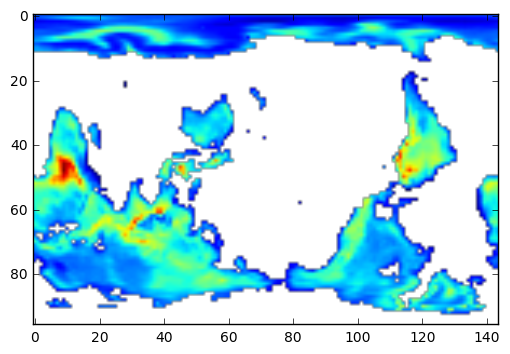

In [36]:

mag = 'low'
ds = ds_list['low']

print(np.sum(np.isnan(res_tot[mag])))
print(np.sum(np.isnan(res_lid[mag])))

print(np.sum(np.isnan(ds['MML_evap_rs'].values[:])))
print(np.sum(np.isnan(ds['MML_rah'].values[:])))

# I bet those are the ocean points...
print(np.nansum(ocn_glc_mask))
print(np.size(res_tot[mag]))
#plt.imshow(ocn_glc_mask)
print(np.nansum(landmask))
print(np.shape(res_lid[mag]))
plt.imshow(np.mean(res_lid[mag],0))

2 - Calculate the atmospheric sensitivity to the total resistance, again using a linear fit (except now the "x-axis" values are spatially varying).

In [37]:
# sklearn linear_model , pearson r

# Linear regression

slope = {}
intercept = {}
r_value = {}
p_value = {}
std_err = {}
r_xvals = {}

sensitivity = {}

#for prop in sfc_props:

# manually do prop = rs ... repeat for prop = hc later. 
prop = 'rs'
prop2 = 'tot_res'
prop3 = 'beta_res'
    
#-----------------------------
#  Do the regression for total resistance
#-----------------------------
    
# Get the perturbation values, make an np.array, which should be 3 x lat x lon ()
# for evaprs, now instead of regressing agains the prescribed bulk lid rs, I'm
# regressing against the calculated total resistance.
xvals = np.array([res_tot['low'], res_tot['med'], res_tot['high']])
print(np.shape(xvals))
print(np.size(xvals))
print(np.size(xvals)/3)
print(np.max(xvals))
print(np.max(res_tot['low']))
print(np.max(res_tot['med']))
print(np.max(res_tot['high']))
print(np.max(res_beta['low']))
print(np.shape(res_beta['low']))



(3, 12, 96, 144)
497664
165888.0
nan
nan
nan
nan
nan
(12, 96, 144)


/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


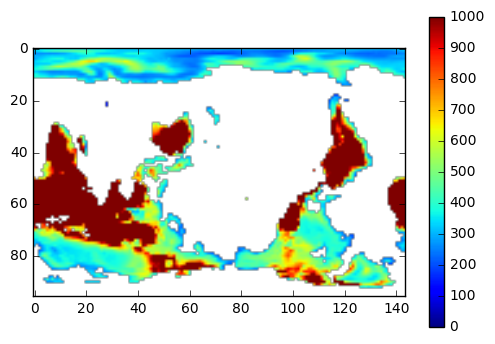

In [38]:
plt.imshow(np.nanmean(res_tot['low'],0))
plt.colorbar()
plt.clim([0,1000])

/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


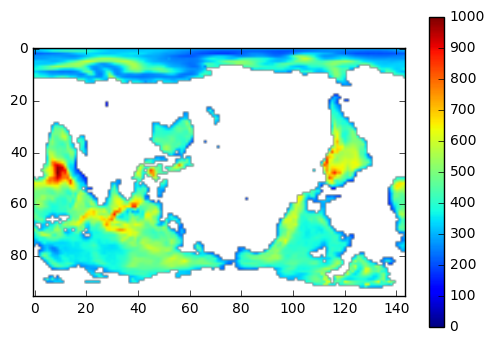

In [39]:
plt.imshow(np.nanmean(res_lid['low'],0))
plt.colorbar()
plt.clim([0,1000])

/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


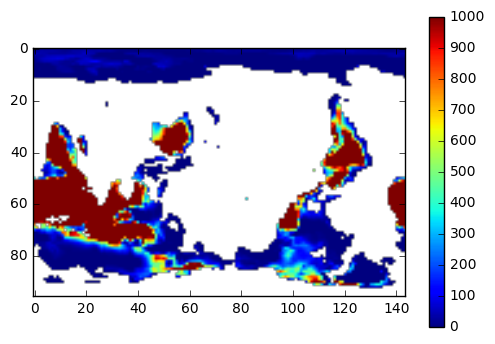

In [40]:
plt.imshow(np.nanmean(res_beta['low'],0))
plt.colorbar()
plt.clim([0,1000])

Make a "beta mask" where all points with a $\beta < a$ (for, for example, $a=0.05$) get a nan-mask, so that 

/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


(12, 96, 144)
(96, 144)


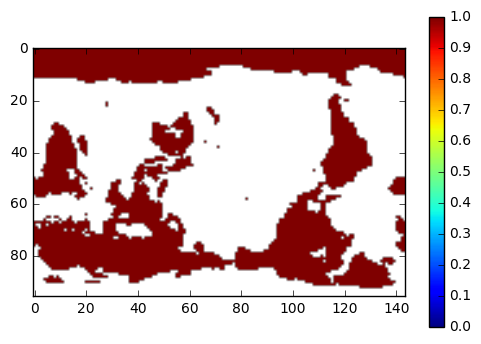

In [41]:
plt.imshow(np.nanmean(beta_mask['low'],0))
print(np.shape(beta_mask['low']))
print(np.shape(np.nanmean(beta_mask['low'],0)))
plt.colorbar()
plt.clim([0,1])

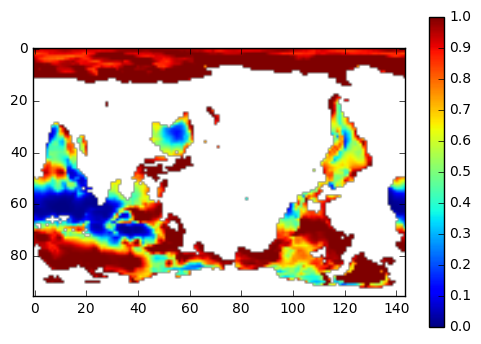

In [42]:
plt.imshow(np.mean(beta['low'],0))

plt.colorbar()
plt.clim([0,1])

In [43]:

# Also grab the perturbations to evap_rs so I can make a map of how linear the effective total resistance change
# is with respect to the prescribed lid change:
xrs = np.array(pert[prop])
print(np.shape(xrs))
k = np.size(xrs)
print(k)

# take linear regression of xvals to xrs, to see how linear the total resistance is wrt the prescribed lid resistance
# also store r values here. 

# create an "empty" model
model = linear_model.LinearRegression()


(3,)
3


In [44]:

# vectorize xvalues of resistance:
xvals_v = xvals.reshape(k,-1)
print(np.shape(xvals_v))
print(np.max(xvals_v))

# Fit the model to tmp_data
model.fit(xrs[:,None], xvals_v)

(3, 165888)
nan


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:

# grab atmospheric response data for current property, make an np.array
# use the atmospheric response in the evap_rs experiments
raw_data = np.array(atm_resp[prop])
# flatten response data into a single long vector (Thanks to Andre for showing me how to do this whole section)
raw_data_v = raw_data.reshape(k, -1)
    
    
# create an "empty" model
model = linear_model.LinearRegression()
    
# Fit the model to tmp_data
model.fit(xvals[:, None], raw_data_v)
    
#  grab the linear fit vector
slope_vector = model.coef_
intercept_vector = model.intercept_
    
# put back into lat/lon (hard coded to be 2.5 degrees right now...)
slope[prop1] = slope_vector.reshape(96,144)
intercept[prop1] = intercept_vector.reshape(96,144)
    
#-----------------------------
#   Calculate the r^2 value
#-----------------------------

# grab the linear fit using the slope and intercept, so we can calculate the correlation coefficient
fit_data_v = np.transpose(slope_vector*xvals)
#print(np.shape(fit_data_v))
#print(np.shape(raw_data_v))
 
# Calculate r value
#r_v, p_v = stats.pearsonr(raw_data_v, fit_data_v)

#r_v = np.corrcoef(x=raw_data_v,y=fit_data_v,rowvar=0)
    
# Going to do this by hand until I figure out how to do it on a matrix...
#print(np.size(raw_data_v,1))
x_bar = np.mean(xvals)
std_x = stats.tstd(xvals)
#print(x_bar)
#print(std_x)
    
#print((np.shape(raw_data_v[1,:])))
#print(np.shape(raw_data_v))
#print(np.shape(fit_data_v))
r_v = np.zeros(np.shape(raw_data_v[0,:]))
p_v = np.zeros(np.shape(raw_data_v[0,:]))
#print(np.shape(r_v))
    
for j in range(np.size(raw_data_v,1)):
       
    # compare to using the pearson-r function:
    r, p = stats.pearsonr(raw_data_v[:,j],fit_data_v[:,j])
    r_v[j] = r
    p_v[j] = p

  
#print(np.shape(r_v.reshape(96,144)))
    
r_value[prop1] = r_v.reshape(96,144)
p_value[prop1] = p_v.reshape(96,144)



3 - plot the change in atm per change in sfc, and the inverse (how big a change in sfc is needed for a change in atm), and the r^2... and maybe here it would also be useful to have a map of the beta's floating around so we can see which regions are beta-dominated... yes... so also include a map of $(res/\beta - res)$, the $\beta$ portion of the total resistance. Maybe do a 2x2 plot so they can be a bit bigger.  

## Recalculate regression using the *effective* surface albedo backout out of FSNS FSNSC so that we're looking at response to actual local change (still has global effects)